**Time Series ForecasterAutoreg**

The goal is to predict what the demand for bike rentals would have been in 2020 if there had been no COVID-19 pandemic. So far we have found the best model Random Forest Regressor with 80.21% accuracy. Now I am using data from 2018 and 2019 to predict 2020.

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [4]:
import glob

# Get a list of all CSV files in the directory
file_list = glob.glob('F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\*.csv')


# Create an empty list to hold the DataFrames
df_list = []

# Loop through the CSV files and read them into DataFrames
for file in file_list:
    # Check if the file name contains the years 2019, 2020, or 2021
    if '2018' in file or '2019' in file or '2020' in file:
        # Read the CSV file into a DataFrame and rename the columns
        print(file)
        df = pd.read_csv(file)
        df = df.rename(columns={'ride_id': 'Ride ID', 'rideable_type': 'Rideable Type',
                                'started_at': 'Start date', 'ended_at': 'End date',
                                'start_station_name': 'Start station', 'start_station_id': 'Start station number',
                                'end_station_name': 'End station', 'end_station_id': 'End station number',
                                'start_lat': 'Start station latitude', 'start_lng': 'Start station longitude',
                                'end_lat': 'End station latitude', 'end_lng': 'End station longitude',
                                'Duration': 'Duration (seconds)', 'Bike number': 'Bike Number',
                                'member_casual': 'Member type'})
        #df = df[['Start date', 'End date', 'Member Type']]  # Select only the columns you need
        df_list.append(df)

# Concatenate the DataFrames
df = pd.concat(df_list, ignore_index=True)

F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201801_capitalbikeshare_tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201802-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201803-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201804-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201805-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201806-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201807-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201808-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201809-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201810-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201811-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201812-capitalbikeshare-tripdata.csv
F:\DataSciCAB\DataSci\Bike\Bike-DS\cov19\201901-capitalbikeshare

Step 1. Prepare the DATA

In [4]:
df.head()

,Duration (seconds),Start date,End date,Start station number,Start station,End station number,End station,Bike Number,Member type,Ride ID,Rideable Type,Start station latitude,Start station longitude,End station latitude,End station longitude
0,552.0,2018-01-01 00:05:06,2018-01-01 00:14:18,31104.0,Adams Mill & Columbia Rd NW,31400.0,Georgia & New Hampshire Ave NW,W00886,Member,NaN,NaN,NaN,NaN,NaN,NaN
1,1282.0,2018-01-01 00:14:30,2018-01-01 00:35:53,31321.0,15th St & Constitution Ave NW,31321.0,15th St & Constitution Ave NW,W01435,Casual,NaN,NaN,NaN,NaN,NaN,NaN
2,1265.0,2018-01-01 00:14:53,2018-01-01 00:35:58,31321.0,15th St & Constitution Ave NW,31321.0,15th St & Constitution Ave NW,W21242,Casual,NaN,NaN,NaN,NaN,NaN,NaN
3,578.0,2018-01-01 00:15:31,2018-01-01 00:25:09,31406.0,14th & Upshur St NW,31103.0,16th & Harvard St NW,W21322,Casual,NaN,NaN,NaN,NaN,NaN,NaN
4,372.0,2018-01-01 00:18:02,2018-01-01 00:24:15,31618.0,4th & East Capitol St NE,31619.0,Lincoln Park / 13th & East Capitol St NE,W00119,Member,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#choose the columns 
df = df[['Start date', 'Member type']]

In [6]:
#to replace some values
df['Member type'] = df['Member type'].replace({'Member': 'member', 'Casual': 'casual'})

In [7]:
#rename columns 
for col in df.columns:
    df.rename(columns={col:col.lower().replace(" ","_")},inplace=True)

df.head(0)

,start_date,member_type


In [8]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [9]:
casual = df[df['member_type'] == 'casual'].groupby(pd.Grouper(key = 'start_date', freq = 'MS')).count().rename(columns={'member_type': 'casual_cnt'}).reset_index()
casual = casual[['start_date', "casual_cnt"]]
casual.head()

,start_date,casual_cnt
0,2018-01-01,16999
1,2018-02-01,21833
2,2018-03-01,54219
3,2018-04-01,89602
4,2018-05-01,102303


In [10]:
member = df[df['member_type'] == 'member'].groupby(pd.Grouper(key = 'start_date', freq = 'MS')).count().rename(columns={'member_type': 'member_cnt'}).reset_index()
member = member[['start_date', 'member_cnt']]
member.head()

,start_date,member_cnt
0,2018-01-01,151591
1,2018-02-01,160545
2,2018-03-01,184779
3,2018-04-01,239305
4,2018-05-01,271812


In [11]:
df= pd.merge(member,casual, how='outer', on = "start_date")
df.head()

,start_date,member_cnt,casual_cnt
0,2018-01-01,151591,16999
1,2018-02-01,160545,21833
2,2018-03-01,184779,54219
3,2018-04-01,239305,89602
4,2018-05-01,271812,102303


In [12]:
df = df.assign(total = df['member_cnt'] + df['casual_cnt'])

In [13]:
df.head()

,start_date,member_cnt,casual_cnt,total
0,2018-01-01,151591,16999,168590
1,2018-02-01,160545,21833,182378
2,2018-03-01,184779,54219,238998
3,2018-04-01,239305,89602,328907
4,2018-05-01,271812,102303,374115


In [13]:
data = df[['start_date', 'total'] ]

In [15]:
data.head()

,start_date,total
0,2018-01-01,168590
1,2018-02-01,182378
2,2018-03-01,238998
3,2018-04-01,328907
4,2018-05-01,374115


In [14]:
data = data.set_index('start_date')
data = data.rename(columns={'total': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y
start_date,
2018-01-01,168590
2018-02-01,182378
2018-03-01,238998
2018-04-01,328907
2018-05-01,374115


Train dates : 2018-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=24)
Test dates  : 2020-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=12)


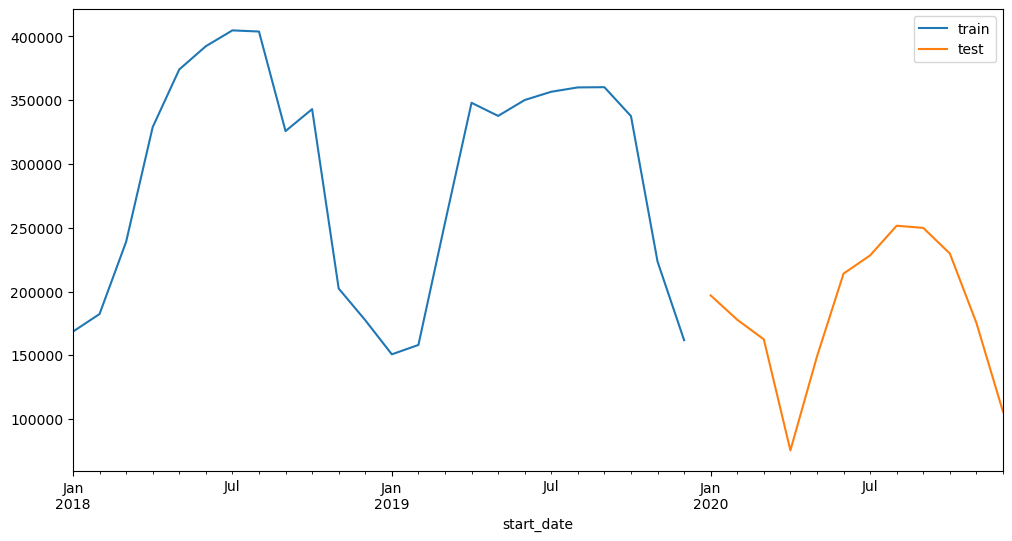

In [15]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

Step 2. Create and Train Forecaster with Random Forest Regressor Model

In [17]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-14 16:41:43 
Last fit date: 2023-04-14 16:41:43 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Forecaster

In [18]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2020-01-01    178554.07
2020-02-01    183357.36
2020-03-01    227816.63
2020-04-01    297162.90
2020-05-01    317275.16
Freq: MS, Name: pred, dtype: float64

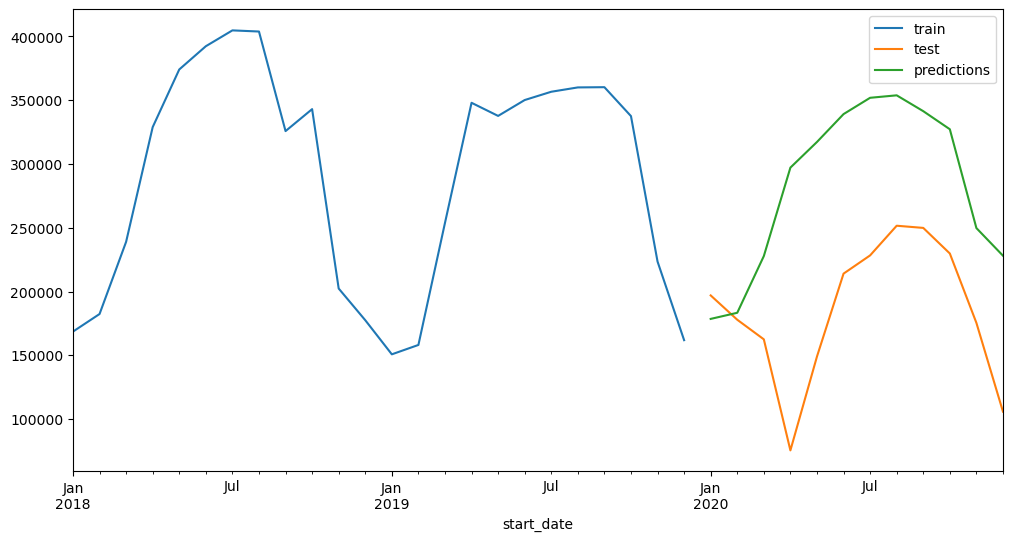

In [19]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

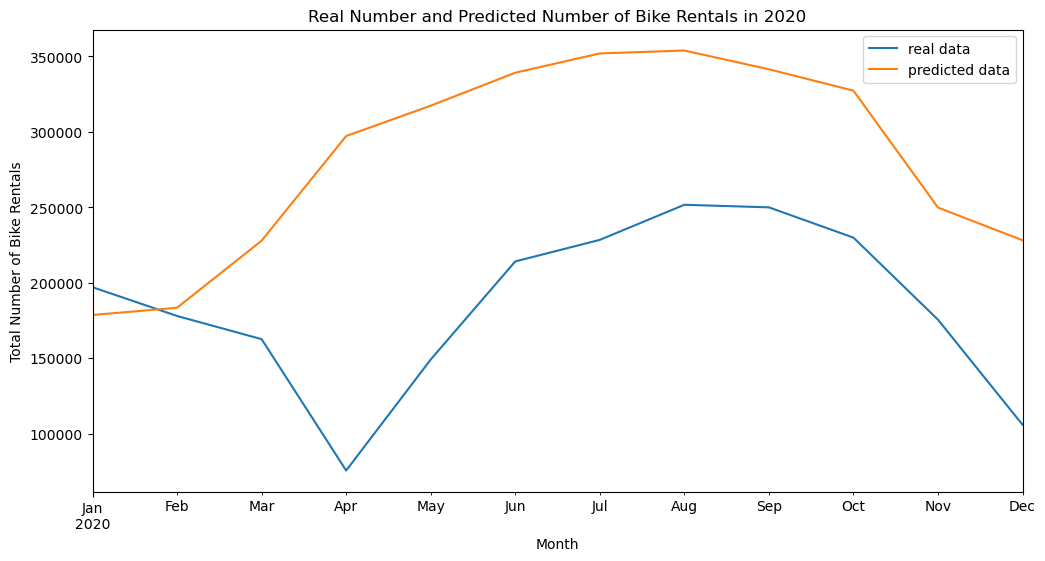

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
data_test['y'].plot(ax=ax, label='real data')
predictions.plot(ax=ax, label='predicted data')
plt.title ('Real Number and Predicted Number of Bike Rentals in 2020')
plt.xlabel('Month')
plt.ylabel('Total Number of Bike Rentals')
ax.legend()

Result: above graph shows the demand for bike rentals using  ForecasterAutoreg and Random Forest Regressor with 80.21% accuracy if there was no covid pandemic.